### Interactive analysis of the harmony batch-corrected adata 

In [ ]:
import numpy as np 
import pandas as pd
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import gc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
%%time
adata = sc.read_h5ad("04_harmony_integrated_adata.h5ad")
adata

In [ ]:
# set the harmony UMAP to the X_umap slot
adata.obsm['X_umap'] = adata.obsm['X_umap_harmony']

In [ ]:
%%time
# check to see if there are good mixing of studies
sc.pl.umap(adata, color=["study"])

In [ ]:
%%time
# visualize the leiden clusters 
sc.pl.umap(adata, color=["leiden_harmony"], legend_loc = "on data")

### Examine the percentage of each leiden cluster per study

In [ ]:
def produce_crosstab_barplot(metadata, cluster_label, metadata_column):
    '''Produce a barplot showing how the cluster_label (e.g. leiden) distributes according to a metadata column (e.g. study)'''

    prop_df = pd.crosstab(metadata[cluster_label], metadata[metadata_column])
    norm_prop_df = prop_df.div(prop_df.sum(axis = 1), axis = 0)

    ax = norm_prop_df.plot(kind = 'bar', stacked=True, figsize=(15, 5), colormap='tab20')
    ax.set_xlabel(cluster_label)
    ax.set_ylabel("Proportion")
    ax.set_title(f"Proportion per {cluster_label} grouped by {metadata_column}")

    # reverse the legend order so that it matches up with the barplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title={cluster_label}, bbox_to_anchor=(1.05, 1), loc='upper left')

    # rotate the x labels
    plt.xticks(rotation=90, ha='right')
    return plt

In [ ]:
adata_metadata = adata.obs

In [ ]:
produce_crosstab_barplot(metadata = adata_metadata, cluster_label = 'leiden_harmony', metadata_column = 'study')

In [ ]:
produce_crosstab_barplot(metadata = adata_metadata, cluster_label = 'leiden_harmony', metadata_column = 'donor_id')

In [ ]:
produce_crosstab_barplot(metadata = adata_metadata, cluster_label = 'leiden_harmony', metadata_column = 'age_status')

The following clusters with high proportions in only one study / high proportion in only a few donors will be dropped
- 2, 3, 8, 15

In [ ]:
%%time
clusters_to_remove = ["2", "3", "8", "15"]
filtered_adata = adata[~adata.obs['leiden_harmony'].isin(clusters_to_remove), :]

In [ ]:
print(f"Number of nuclei removed from highly skewed clusters: {filtered_adata.shape[0] - adata.shape[0]}")

Write this filtered adata and then load this back

In [ ]:
%%time
filtered_adata.write("04B_filtered_harmony.h5ad")

### Restart the kernel here and load back the filtered adata

In [1]:
import numpy as np 
import pandas as pd
import scvi
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import gc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
%%time
filtered_adata = sc.read_h5ad("04B_filtered_harmony.h5ad")
filtered_adata

CPU times: user 16.7 s, sys: 1min 24s, total: 1min 41s
Wall time: 1min 41s


AnnData object with n_obs × n_vars = 2819007 × 16115
    obs: 'age', 'donor_id', 'sex', 'region', 'cell_type', 'disease', 'consistent_cell_type', 'study', 'technology', 'cell_or_nuclei', 'barcode', 'sample_id', 'age_status', 'tech_plus_study', 'disease_binary', 'decade', 'age_group', 'leiden_harmony'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden_harmony', 'donor_id_colors', 'hvg', 'leiden_harmony', 'leiden_harmony_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'study_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'X_umap_no_harmony'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

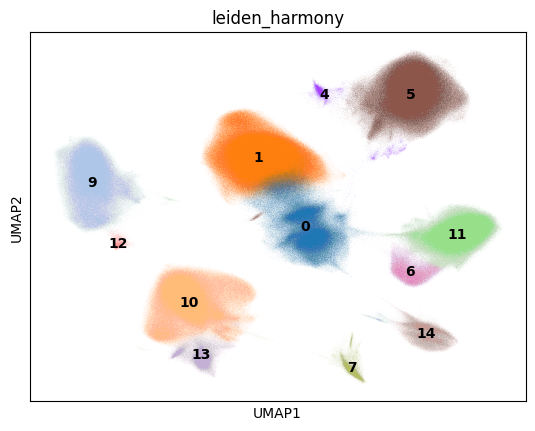

CPU times: user 16 s, sys: 574 ms, total: 16.6 s
Wall time: 16.3 s


In [3]:
%%time
sc.pl.umap(filtered_adata, color = "leiden_harmony", legend_loc = "on data")

### With the remaining clusters, perform cell type annotation

In [ ]:
%%time
#sc.tl.dendrogram(filtered_adata, groupby="leiden_scVI")
#sc.pl.rank_genes_groups_dotplot(filtered_adata, groupby="leiden_scVI", standard_scale="var", n_genes=2, use_rep = "X")

In [18]:
# run this to identify top marker genes per cluster
sc.get.rank_genes_groups_df(filtered_adata, group="12").head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,SLC24A3,49.940952,7.302181,0.000000e+00,0.000000e+00
1,IL18R1,46.828156,7.410700,0.000000e+00,0.000000e+00
2,NTM,46.721752,6.173282,0.000000e+00,0.000000e+00
3,KIT,44.794636,9.290227,0.000000e+00,0.000000e+00
4,BMP2K,42.286903,4.471218,0.000000e+00,0.000000e+00
5,FER,39.492352,3.428108,0.000000e+00,0.000000e+00
6,CPA3,38.911423,9.913393,0.000000e+00,0.000000e+00
7,ARHGAP15,36.125999,3.334801,8.862975e-286,1.785336e-282
8,SMYD3,36.122681,3.226803,9.991823e-286,1.789091e-282
9,PRKCA,33.913654,3.404162,4.191259e-252,6.754214e-249


### Add cell type annotations in metadata field called "scvi_cell_type"

In [19]:
filtered_adata.obs["harmony_cell_type"] = filtered_adata.obs["leiden_harmony"].map(
    {
        "0": "Cardiomyocyte",
        "1": "Cardiomyocyte",
        "4": "Adipocyte",
        "5": "Fibroblast",
        "6": "vSMC",
        "7": "Neuronal",
        "9": "Myeloid",
        "10": "Endothelial",
        "11": "Pericyte",
        "12": "Mast",
        "13": "Endocardial",
        "14": "Lymphoid"
    }
)

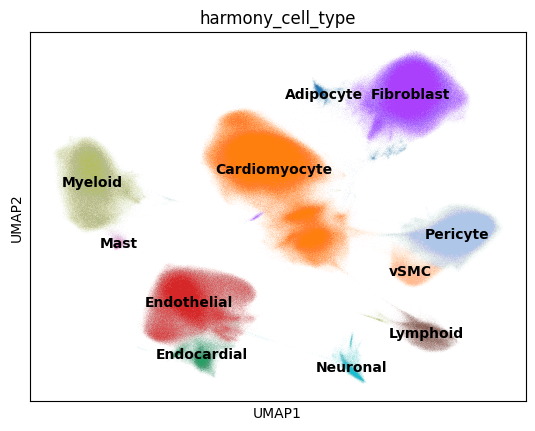

In [20]:
sc.pl.umap(filtered_adata, color=["harmony_cell_type"], legend_loc = "on data")

In [21]:
def produce_crosstab_barplot(metadata, cluster_label, metadata_column):
    '''Produce a barplot showing how the cluster_label (e.g. leiden) distributes according to a metadata column (e.g. study)'''

    prop_df = pd.crosstab(metadata[cluster_label], metadata[metadata_column])
    norm_prop_df = prop_df.div(prop_df.sum(axis = 1), axis = 0)

    ax = norm_prop_df.plot(kind = 'bar', stacked=True, figsize=(15, 5), colormap='tab20')
    ax.set_xlabel(cluster_label)
    ax.set_ylabel("Proportion")
    ax.set_title(f"Proportion per {cluster_label} grouped by {metadata_column}")

    # reverse the legend order so that it matches up with the barplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title={cluster_label}, bbox_to_anchor=(1.05, 1), loc='upper left')

    # rotate the x labels
    plt.xticks(rotation=90, ha='right')
    return plt

In [22]:
adata_metadata = filtered_adata.obs

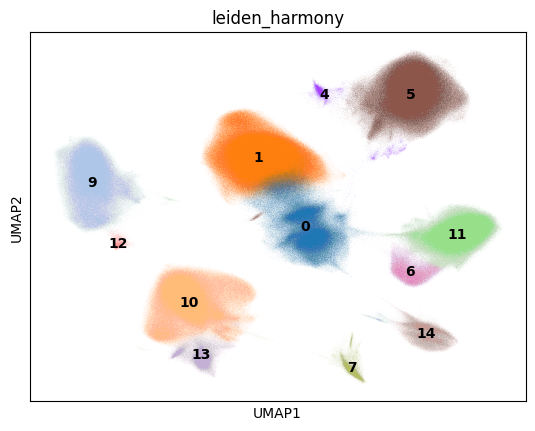

In [23]:
sc.pl.umap(filtered_adata, color=["leiden_harmony"], legend_loc = "on data")

<module 'matplotlib.pyplot' from '/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/matplotlib/pyplot.py'>

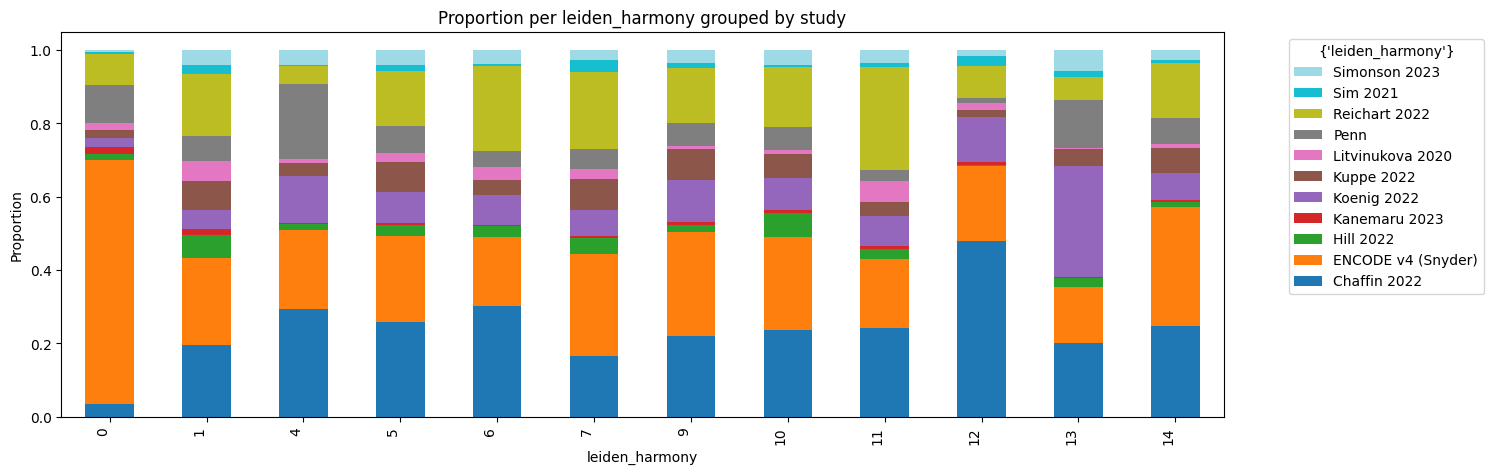

In [24]:
produce_crosstab_barplot(metadata = adata_metadata, cluster_label = 'leiden_harmony', metadata_column = 'study')

#### Now, check the consistency of the annotations of the scVI leiden based cluster and the consistent cell type annotations (based on the original papers)

Examine the cell type proportions for each study

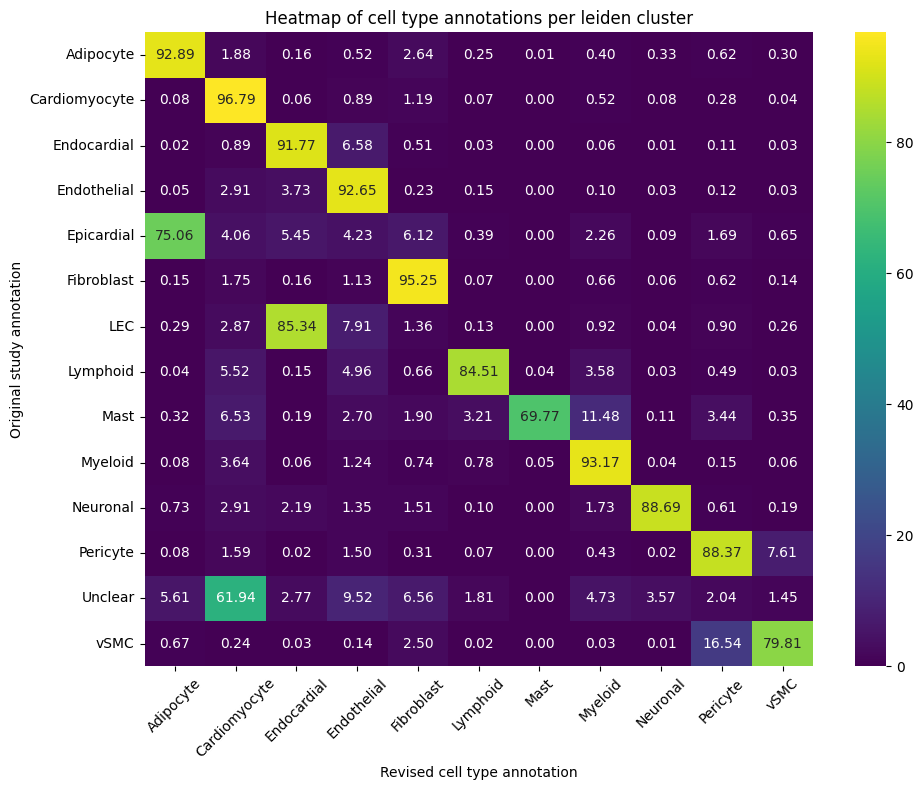

In [25]:
filtered_adata_metadata = filtered_adata.obs

# the first argument will be on the y-axis, while the second will be on the x-axis
consistency_matrix = pd.crosstab(filtered_adata_metadata['consistent_cell_type'], filtered_adata_metadata['harmony_cell_type'])
# normalize so that rows sum to 100%
norm_consistency_matrix = 100 * consistency_matrix.div(consistency_matrix.sum(axis = 1), axis = 0)
norm_consistency_matrix.head()

# plot the heatmap
plt.figure(figsize=(10, 8))  
sns.heatmap(norm_consistency_matrix, cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('Heatmap of cell type annotations per leiden cluster')
plt.xlabel('Revised cell type annotation')
plt.ylabel('Original study annotation')
plt.xticks(rotation=45)  
plt.yticks(rotation=0)   
plt.tight_layout()       
plt.show()   

In [26]:
%%time
filtered_adata.write("04B_filtered_harmony.h5ad")

CPU times: user 41 s, sys: 2min 52s, total: 3min 33s
Wall time: 3min 35s
